In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

BASE_DIR = "/content/gdrive/My Drive/CS282/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip install torcheval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!gdown 1igdG6vjTxfdKmyb6bKF2QDus5e9ViJjc

Downloading...
From: https://drive.google.com/uc?id=1igdG6vjTxfdKmyb6bKF2QDus5e9ViJjc
To: /content/processed.zip
100% 7.03M/7.03M [00:00<00:00, 21.0MB/s]


In [5]:
!unzip -q -o processed.zip

In [28]:
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision
from torchvision.ops import focal_loss
from torchvision import transforms
from PIL import Image

import os
import copy
from pathlib import Path
import matplotlib.pyplot as plt

In [39]:
EPOCHS = 200

In [9]:
# Config device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [10]:
class BananaLeafDiseaseDataset(Dataset):
    def __init__(self, target_dir: str, transform=None):
        self.transform = transform

        # Load image paths
        self.image_paths = list(Path(target_dir).glob('*/*.jpg'))
        self.classes, self.class_to_idx = self.load_classes(target_dir)

    def load_image(self, idx: int):
        return Image.open(self.image_paths[idx])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = self.load_image(idx)
        class_name = self.image_paths[idx].parent.name
        class_idx = self.class_to_idx[class_name]

        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx


    def load_classes(self, target_dir):
        """
            Returns:
                classes[]
                class_to_idx{}
        """
        classes = sorted(entry.name for entry in os.scandir(target_dir) if entry.is_dir())
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

In [11]:
def train_one_epoch(train_loader, model, criterion, optimizer, scheduler):
    # Train mode
    model.train()

    # Track metrics
    loss_epoch = 0
    accuracy_epoch = 0

    # Loop over minibatches
    for inputs, labels in train_loader:
        # Send to device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backprop
        loss.backward()

        # Update parameters
        optimizer.step()

        # Zero gradients
        optimizer.zero_grad()

        # Track loss
        loss_epoch += loss.detach().item()

        # Accuracy
        _, preds = torch.max(outputs, 1)
        accuracy_epoch += torch.sum(preds == labels)/inputs.shape[0]

    # Update learning rate
    scheduler.step()

    return loss_epoch/len(train_loader), accuracy_epoch.item()/len(train_loader)

In [12]:
def evaluate_one_epoch(test_loader, model, criterion):
    # Eval mode
    model.eval()

    # Track metrics
    loss_epoch = 0
    accuracy_epoch = 0

    # Don't update weights
    with torch.no_grad():
        # Loop over minibatches
        for inputs, labels in test_loader:
            # Send to device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Track loss
            loss_epoch += loss.detach().item()

            # Accuracy
            _, preds = torch.max(outputs, 1)
            accuracy_epoch += torch.sum(preds == labels)/inputs.shape[0]

    return loss_epoch/len(test_loader), accuracy_epoch.item()/len(test_loader)

In [14]:
# Plot history
def plot_hist(train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist):
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    plt.plot(train_loss_hist, label='Train_Loss')
    plt.plot(test_loss_hist, label='Val_loss')
    plt.title('Cross Entropy Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_acc_hist, label='Train_Accuracy')
    plt.plot(test_acc_hist, label='Val_Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

In [16]:
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, verbose=True, best_weight_file_name='model.h5'):
    # Initialise outputs
    train_loss_hist = []
    val_loss_hist = []
    train_acc_hist = []
    val_acc_hist = []

    max_val_acc = 0.0
    best_model_weights = copy.deepcopy(model.state_dict())

    # Loop over epochs
    for epoch in range(EPOCHS):
        # Train
        train_loss, train_accuracy = train_one_epoch(train_loader, model, criterion, optimizer, scheduler)

        # Evaluate
        val_loss, val_accuracy = evaluate_one_epoch(val_loader, model, criterion)

        # Track metrics
        train_loss_hist.append(train_loss)
        val_loss_hist.append(val_loss)
        train_acc_hist.append(train_accuracy)
        val_acc_hist.append(val_accuracy)

        # Print loss
        if verbose:
            if (epoch+1)%1==0:
                print(f'Epoch {epoch+1}/{EPOCHS}, loss {train_loss:.5f}, val_loss {val_loss:.5f}, accuracy {train_accuracy:.5f}, val_accuracy {val_accuracy:.5f}')

        # Save best weight
        if val_accuracy > max_val_acc:
          max_val_acc = val_accuracy
          best_model_weights = copy.deepcopy(model.state_dict())

    # Save best weight to file
    torch.save(best_model_weights, BASE_DIR + best_weight_file_name)

    return train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist

In [20]:
basic_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

train_transforms = transforms.Compose([
    transforms.RandomVerticalFlip(p = 0.5),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.ColorJitter(brightness=0.1, saturation=0.1, contrast=0.1),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

In [21]:
train_dataset = BananaLeafDiseaseDataset('./processed/train', transform=train_transforms)
val_dataset = BananaLeafDiseaseDataset('./processed/val', transform=train_transforms)
test_dataset = BananaLeafDiseaseDataset('./processed/test', transform=basic_transforms)

In [22]:
# Address class imbalance
classes = sorted(entry.name for entry in os.scandir('./processed/train') if entry.is_dir())
class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

def get_weights(images):
    num_images = len(images)
    count_per_class = [0] * len(classes)

    for img in images:
        img_class = img.parent.name
        class_idx = class_to_idx[img_class]
        count_per_class[class_idx] += 1

    weight_per_class = [0.0] * len(classes)

    for i in range(len(classes)):
        weight_per_class[i] = float(num_images) / float(count_per_class[i])

    weights = [0] * num_images

    for i, img in enumerate(images):
        img_class = img.parent.name
        class_idx = class_to_idx[img_class]
        weights[i] = weight_per_class[class_idx]

    return weights

In [23]:
weights = get_weights(train_dataset.image_paths)
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))

In [24]:
train_loader = DataLoader(train_dataset, batch_size=20, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=20, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=True)

## Training: Baseline Model (ResNet50)

In [40]:
model = torchvision.models.resnet50()
model.fc = torch.nn.Sequential(
    torch.nn.Linear(
        in_features=2048,
        out_features=3
    ),
    torch.nn.Sigmoid()
)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6)
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
scheduler = torch.optim.lr_scheduler.CyclicLR(
            optimizer, base_lr=1e-6, max_lr=1e-4, cycle_momentum=False
        )


In [41]:
train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist = train_model(model, criterion, optimizer, scheduler, train_loader, test_loader, verbose=True, best_weight_file_name='Best-ResNet.h5')

Epoch 1/200, loss 1.09598, val_loss 1.08496, accuracy 0.35833, val_accuracy 0.42917
Epoch 2/200, loss 1.07912, val_loss 1.06854, accuracy 0.41406, val_accuracy 0.49583
Epoch 3/200, loss 1.06382, val_loss 1.05504, accuracy 0.42943, val_accuracy 0.48125
Epoch 4/200, loss 1.06013, val_loss 1.04916, accuracy 0.44661, val_accuracy 0.51875
Epoch 5/200, loss 1.04589, val_loss 1.03417, accuracy 0.48906, val_accuracy 0.52917
Epoch 6/200, loss 1.04741, val_loss 1.03350, accuracy 0.49792, val_accuracy 0.57500
Epoch 7/200, loss 1.04595, val_loss 1.02608, accuracy 0.48411, val_accuracy 0.57708
Epoch 8/200, loss 1.03728, val_loss 1.02959, accuracy 0.49974, val_accuracy 0.55417
Epoch 9/200, loss 1.03414, val_loss 1.02592, accuracy 0.50625, val_accuracy 0.58333
Epoch 10/200, loss 1.03512, val_loss 1.02216, accuracy 0.48255, val_accuracy 0.58750
Epoch 11/200, loss 1.03609, val_loss 1.02045, accuracy 0.48698, val_accuracy 0.56667
Epoch 12/200, loss 1.02789, val_loss 1.00872, accuracy 0.51771, val_accura

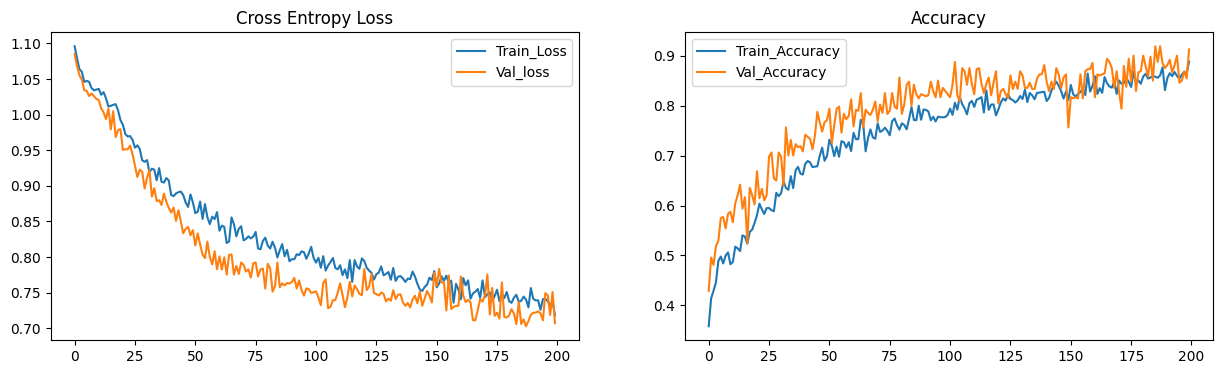

In [42]:
plot_hist(train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist)

In [ ]:
# Define MLP Mixer

In [25]:
from torch import nn
from einops.layers.torch import Rearrange

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class MixerBlock(nn.Module):
    def __init__(self, dim, num_patch, token_dim, channel_dim, dropout = 0.):
        super().__init__()

        self.token_mix = nn.Sequential(
            nn.LayerNorm(dim),
            Rearrange('b n d -> b d n'),
            FeedForward(num_patch, token_dim, dropout),
            Rearrange('b d n -> b n d')
        )

        self.channel_mix = nn.Sequential(
            nn.LayerNorm(dim),
            FeedForward(dim, channel_dim, dropout),
        )

    def forward(self, x):
        x = x + self.token_mix(x)
        x = x + self.channel_mix(x)
        return x

class MLPMixer(nn.Module):
    def __init__(
        self,
        in_channels,
        dim,
        num_classes,
        patch_size,
        image_size,
        depth,
        token_dim,
        channel_dim
    ):
        super().__init__()

        assert image_size % patch_size == 0, 'Image dimensions must be divisible by the patch size.'
        self.num_patch =  (image_size// patch_size) ** 2
        self.to_patch_embedding = nn.Sequential(
            nn.Conv2d(in_channels, dim, patch_size, patch_size),
            Rearrange('b c h w -> b (h w) c'),
        )

        self.mixer_blocks = nn.ModuleList([])

        for _ in range(depth):
            self.mixer_blocks.append(MixerBlock(dim, self.num_patch, token_dim, channel_dim))

        self.layer_norm = nn.LayerNorm(dim)

        self.mlp_head = nn.Sequential(
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        x = self.to_patch_embedding(x)
        for mixer_block in self.mixer_blocks:
            x = mixer_block(x)

        x = self.layer_norm(x)
        x = x.mean(dim=1)
        return self.mlp_head(x)

## Training: MLPMixer

In [43]:
model_mixer = MLPMixer(in_channels=3, image_size=224, patch_size=16, num_classes=3,
                     dim=256, depth=4, token_dim=128, channel_dim=512)
model_mixer.to(device)
optimizer = torch.optim.AdamW(model_mixer.parameters(), lr=1e-6)
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
scheduler = torch.optim.lr_scheduler.CyclicLR(
            optimizer, base_lr=1e-6, max_lr=1e-4, cycle_momentum=False
            )

In [44]:
train_loss_hist_mixer, test_loss_hist_mixer, train_acc_hist_mixer, test_acc_hist_mixer = train_model(model_mixer, criterion, optimizer, scheduler, train_loader, test_loader, verbose=True, best_weight_file_name='Best-Mixer-tiny.h5')

Epoch 1/200, loss 1.14597, val_loss 1.10310, accuracy 0.31042, val_accuracy 0.40625
Epoch 2/200, loss 1.09677, val_loss 1.06470, accuracy 0.39870, val_accuracy 0.54167
Epoch 3/200, loss 1.06122, val_loss 1.04646, accuracy 0.51432, val_accuracy 0.48125
Epoch 4/200, loss 1.04041, val_loss 1.01214, accuracy 0.50859, val_accuracy 0.54167
Epoch 5/200, loss 1.01694, val_loss 1.00420, accuracy 0.52839, val_accuracy 0.57292
Epoch 6/200, loss 1.00060, val_loss 0.98149, accuracy 0.56380, val_accuracy 0.56250
Epoch 7/200, loss 0.99123, val_loss 0.97132, accuracy 0.54896, val_accuracy 0.57708
Epoch 8/200, loss 0.98632, val_loss 0.96688, accuracy 0.54401, val_accuracy 0.56250
Epoch 9/200, loss 0.96079, val_loss 0.95156, accuracy 0.57865, val_accuracy 0.64792
Epoch 10/200, loss 0.94546, val_loss 0.94874, accuracy 0.58958, val_accuracy 0.60000
Epoch 11/200, loss 0.94492, val_loss 0.93635, accuracy 0.57161, val_accuracy 0.63125
Epoch 12/200, loss 0.93603, val_loss 0.91792, accuracy 0.59844, val_accura

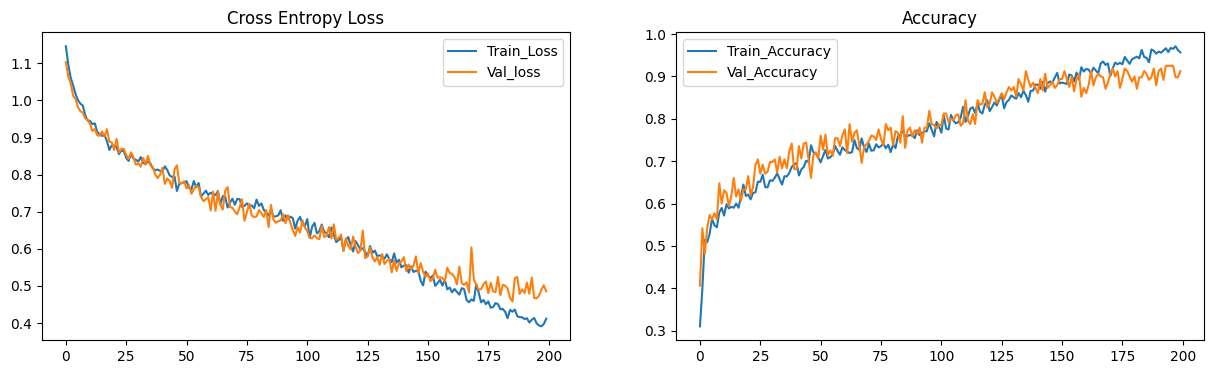

In [45]:
plot_hist(train_loss_hist_mixer, test_loss_hist_mixer, train_acc_hist_mixer, test_acc_hist_mixer)

## Training: MLPMixer (2)

In [ ]:
model_mixer_2 = MLPMixer(in_channels=3, image_size=224, patch_size=16, num_classes=3,
                     dim=256, depth=6, token_dim=128, channel_dim=512)
model_mixer_2.to(device)
optimizer = torch.optim.AdamW(model_mixer_2.parameters(), lr=1e-6)
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
scheduler = torch.optim.lr_scheduler.CyclicLR(
            optimizer, base_lr=1e-6, max_lr=1e-4, cycle_momentum=False
            )

In [ ]:
train_loss_hist_mixer_2, test_loss_hist_mixer_2, train_acc_hist_mixer_2, test_acc_hist_mixer_2 = train_model(model_mixer_2, criterion, optimizer, scheduler, train_loader, test_loader, verbose=True, best_weight_file_name='Best-Mixer-mid.h5')

In [ ]:
plot_hist(train_loss_hist_mixer_2, test_loss_hist_mixer_2, train_acc_hist_mixer_2, test_acc_hist_mixer_2)

## Evaluation

In [49]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
import numpy as np

def get_metrics(test_loader, model):
    # Eval mode
    model.eval()

    y_preds = []
    y_true = []
    y_proba = []
    # Don't update weights
    with torch.no_grad():
        # Loop over minibatches
        for inputs, labels in test_loader:
            # Send to device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            proba = nn.functional.softmax(outputs, dim=1)

            # Accuracy
            _, preds = torch.max(outputs, 1)

            preds_cpu = preds.cpu().detach().numpy()
            labels_cpu = labels.cpu().detach().numpy()
            proba_cpu = proba.cpu().detach().numpy()

            y_preds.extend(preds_cpu.tolist())
            y_true.extend(labels_cpu.tolist())
            y_proba.extend(proba_cpu.tolist())

    y_preds = np.array(y_preds)
    y_true = np.array(y_true)
    y_proba = np.array(y_proba)
    print('Accuracy:', accuracy_score(y_true, y_preds))
    print('Precision:', precision_score(y_true, y_preds, average='macro'))
    print('Recall:', recall_score(y_true, y_preds, average='macro'))
    print('F1-score:', f1_score(y_true, y_preds, average='macro'))
    print('AUC:', roc_auc_score(y_true, y_proba, multi_class='ovr'))


In [46]:
# Download baseline model
!gdown 1-1VhcgQShzwL_DWFMAcahuqGEJtPUt8k

Downloading...
From: https://drive.google.com/uc?id=1-1VhcgQShzwL_DWFMAcahuqGEJtPUt8k
To: /content/Best-ResNet.h5
100% 94.4M/94.4M [00:01<00:00, 63.4MB/s]


In [50]:
baseline_model = torchvision.models.resnet50()
baseline_model.fc = torch.nn.Sequential(
    torch.nn.Linear(
        in_features=2048,
        out_features=3
    ),
    torch.nn.Sigmoid()
)
baseline_model.to(device)
baseline_model.load_state_dict(torch.load('Best-ResNet.h5'))

<All keys matched successfully>

In [51]:
get_metrics(test_loader, baseline_model)

Accuracy: 0.910958904109589
Precision: 0.9121384369350577
Recall: 0.9113888888888888
F1-score: 0.9117009727288519
AUC: 0.9679591836734693


In [83]:
# Download best model

In [52]:
!gdown 1-4eOiGqAVWT7m3LB6KLGF78Fy_v1ZpQf

Downloading...
From: https://drive.google.com/uc?id=1-4eOiGqAVWT7m3LB6KLGF78Fy_v1ZpQf
To: /content/Best-Mixer-tiny.h5
100% 5.85M/5.85M [00:00<00:00, 83.1MB/s]


In [53]:
best_model_mixer_4 = MLPMixer(in_channels=3, image_size=224, patch_size=16, num_classes=3,
                     dim=256, depth=4, token_dim=128, channel_dim=512)
best_model_mixer_4.to(device)
best_model_mixer_4.load_state_dict(torch.load('Best-Mixer-tiny.h5'))

<All keys matched successfully>

In [54]:
get_metrics(test_loader, best_model_mixer_4)

Accuracy: 0.9178082191780822
Precision: 0.9195127623699052
Recall: 0.9180555555555556
F1-score: 0.9179406972955361
AUC: 0.9826729024943311


In [55]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params


In [58]:
count_parameters(baseline_model)

+------------------------------+------------+
|           Modules            | Parameters |
+------------------------------+------------+
|         conv1.weight         |    9408    |
|          bn1.weight          |     64     |
|           bn1.bias           |     64     |
|    layer1.0.conv1.weight     |    4096    |
|     layer1.0.bn1.weight      |     64     |
|      layer1.0.bn1.bias       |     64     |
|    layer1.0.conv2.weight     |   36864    |
|     layer1.0.bn2.weight      |     64     |
|      layer1.0.bn2.bias       |     64     |
|    layer1.0.conv3.weight     |   16384    |
|     layer1.0.bn3.weight      |    256     |
|      layer1.0.bn3.bias       |    256     |
| layer1.0.downsample.0.weight |   16384    |
| layer1.0.downsample.1.weight |    256     |
|  layer1.0.downsample.1.bias  |    256     |
|    layer1.1.conv1.weight     |   16384    |
|     layer1.1.bn1.weight      |     64     |
|      layer1.1.bn1.bias       |     64     |
|    layer1.1.conv2.weight     |  

23514179

In [57]:
count_parameters(best_model_mixer_4)

+-------------------------------------------+------------+
|                  Modules                  | Parameters |
+-------------------------------------------+------------+
|        to_patch_embedding.0.weight        |   196608   |
|         to_patch_embedding.0.bias         |    256     |
|     mixer_blocks.0.token_mix.0.weight     |    256     |
|      mixer_blocks.0.token_mix.0.bias      |    256     |
|  mixer_blocks.0.token_mix.2.net.0.weight  |   25088    |
|   mixer_blocks.0.token_mix.2.net.0.bias   |    128     |
|  mixer_blocks.0.token_mix.2.net.3.weight  |   25088    |
|   mixer_blocks.0.token_mix.2.net.3.bias   |    196     |
|    mixer_blocks.0.channel_mix.0.weight    |    256     |
|     mixer_blocks.0.channel_mix.0.bias     |    256     |
| mixer_blocks.0.channel_mix.1.net.0.weight |   131072   |
|  mixer_blocks.0.channel_mix.1.net.0.bias  |    512     |
| mixer_blocks.0.channel_mix.1.net.3.weight |   131072   |
|  mixer_blocks.0.channel_mix.1.net.3.bias  |    256    

1455891